In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

np.warnings.filterwarnings('ignore')

In [2]:
import wave

In [3]:
from scipy.io import wavfile
samplerate, data = wavfile.read(r'C:\Users\E530C\Desktop\AI Healthcare\all_files\BR 31 Coarse Crackles 1.wav')


Text(0, 0.5, 'Frequency(Hz)')

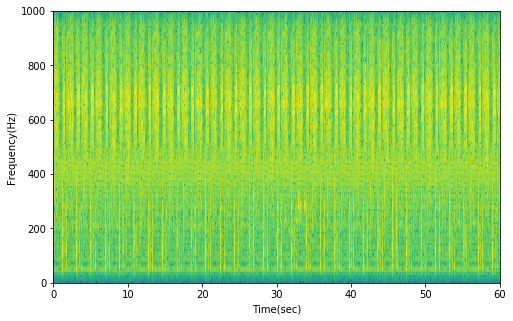

In [4]:
fs = 2000
plt.figure(figsize = (8,5))
plt.specgram(data, Fs=fs, NFFT =None, noverlap = None, xextent = [0, len(data) / fs]);
plt.xlabel('Time(sec)')
plt.ylabel('Frequency(Hz)')

In [5]:
def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

Text(0, 0.5, 'Frequency(Hz)')

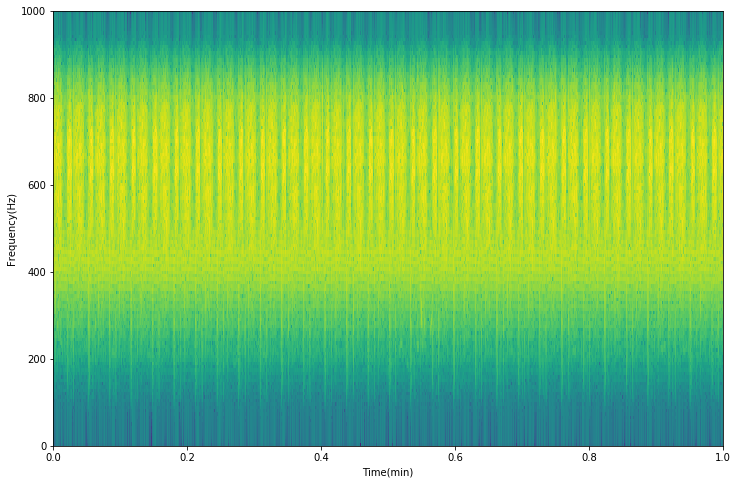

In [6]:
plt.figure(figsize = (12,8))
filtered_sig = BandpassFilter(data, (400,800), fs = fs)
plt.specgram(filtered_sig, Fs=fs, NFFT =None, noverlap = None, xextent = [0, len(data) / fs / 60]);
plt.xlabel('Time(min)')
plt.ylabel('Frequency(Hz)')

In [7]:
# the Fourier transform
freqs = np.fft.rfftfreq(len(data), 1/fs)
fft = np.fft.rfft(data)


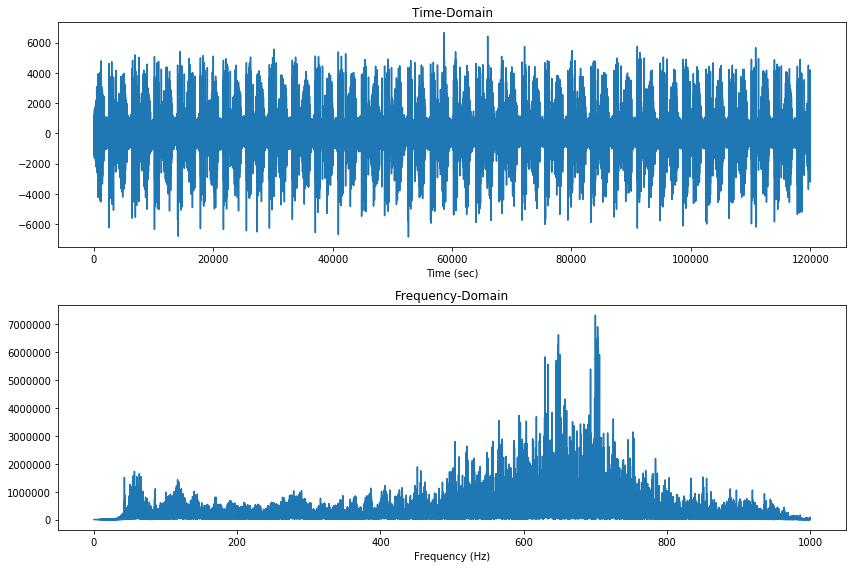

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)

plt.plot(data)
plt.title('Time-Domain')
plt.xlabel('Time (sec)')
plt.subplot(2,1,2)
plt.plot(freqs, np.abs(fft))
plt.title('Frequency-Domain')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

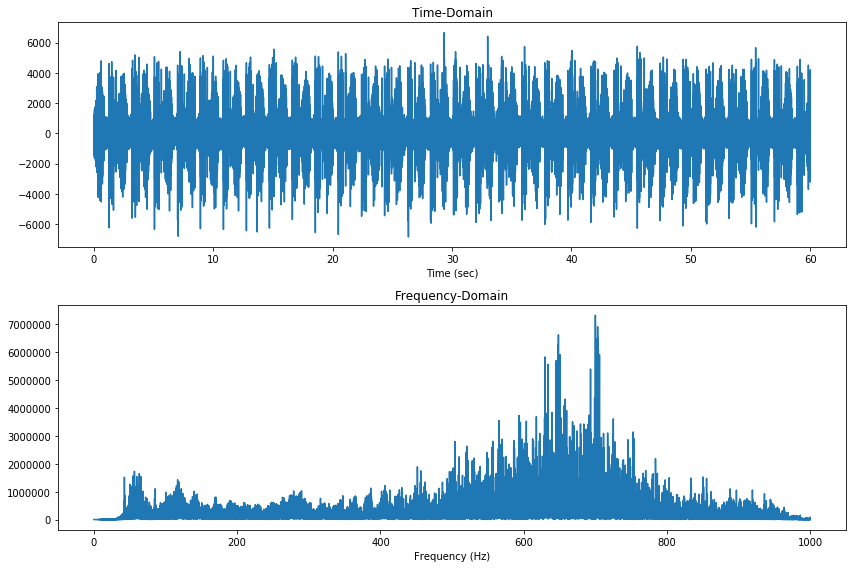

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
ts = np.arange(0, 60, 1/fs)
plt.plot(ts, data)
plt.title('Time-Domain')
plt.xlabel('Time (sec)')
plt.subplot(2,1,2)
plt.plot(freqs, np.abs(fft))
plt.title('Frequency-Domain')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

### Using the Pan-Tompkins methods

#preprocessing involves the following steps
1. Bandpass filter 
2. 1-Sample difference (preserves sharp slopes and suppresses the small ones)
3. Square
3. Moving Sum (over a fixed window length. we can fully take advanatge of all the energy in the QRS complex (150ms) while
              attenuating the other spikes(shorter or longer))

In [10]:
def BandpassFilter(signal, fs=2000):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (400, 800), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=2000):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.15))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, pks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[pks])
    return pks[filtered_signal[pks] > thresh]

def LocalizeMaxima(signal, pks, fs):
    """Find R-wave peaks in the original, unfiltered signal.
    
    This function is mostly for aesthetic purposes and not part of the algorithm.
    We only do it here because we know that the R-waves are pointing up.
    """
    tpks = []
    n_samples = int(round(fs * 0.15))
    for p in pks:
        tpks.append(np.argmax(signal[p - n_samples: p + n_samples]) + p - n_samples)
    return tpks

def PanTompkinsPeaks(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    fiducial_marks = ThresholdPeaks(filtered_signal, FindPeaks(filtered_signal))
    return LocalizeMaxima(signal, fiducial_marks, fs)

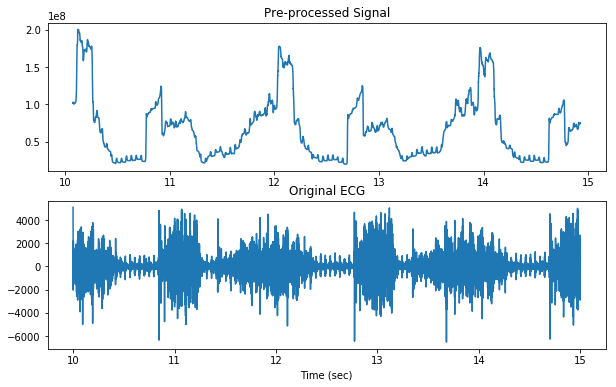

In [11]:
ts = np.arange(len(data)) / fs
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(ts[20001:30000], MovingSum(np.square(np.diff(BandpassFilter(data, 3000)[20000:30000])), fs))
plt.title('Pre-processed Signal')
plt.subplot(2,1,2);
plt.plot(ts[20000:30000], data[20000:30000]);
plt.title('Original ECG')
plt.xlabel('Time (sec)');

In [12]:
def Plot(x, fs, xlim=None, title=''):
    plt.figure(figsize=(12, 8))
    ts = np.arange(len(x)) / fs
    plt.plot(ts, x)
    pks = PanTompkinsPeaks(x, fs)
    plt.plot(ts[pks], x[pks], 'r.', ms=10)
    plt.xlabel('Time (sec)')
    plt.title(title)
    if xlim is not None:
        plt.xlim((ts[xlim[0]], ts[xlim[1]]))

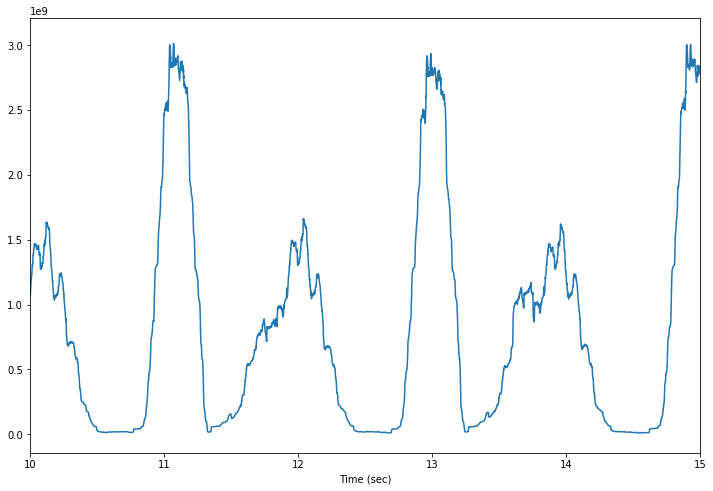

In [13]:
Plot((MovingSum(np.square(np.diff(BandpassFilter(data))))), 2000, (20000, 30000) )

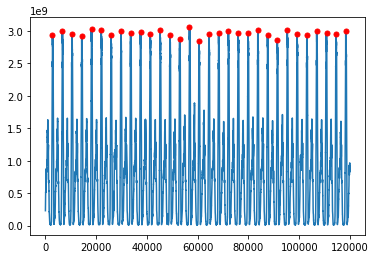

In [14]:
plt.plot(figsize =(12,8))
pks = sp.signal.find_peaks((MovingSum(np.square(np.diff(BandpassFilter(data))))), height = 4000, distance = 3000)[0]
plt.plot((MovingSum(np.square(np.diff(BandpassFilter(data))))))
plt.plot(pks, (MovingSum(np.square(np.diff(BandpassFilter(data)))))[pks], 'r.', ms = 10)

In [15]:
60 / (np.diff (pks) /fs)

array([30.46458492, 32.25806452, 31.39717425, 30.78501796, 31.25      ,
       31.25      , 30.92783505, 31.25      , 30.28773347, 32.27541689,
       30.62005614, 31.25      , 31.73763555, 30.92783505, 31.75443239,
       30.92783505, 31.25      , 31.68735147, 30.8245569 , 31.39717425,
       31.23373243, 30.80082136, 31.25      , 30.6122449 , 31.25      ,
       31.25814014, 30.92783505, 31.01576635, 32.16295899, 31.25      ])

In [16]:
Average_pulse_rate = np.mean(60 / (np.diff(pks) / fs))
Average_pulse_rate

31.209473435587793

#### Improving the Algorithm

In [28]:
def BandpassFilter(signal, fs=2000):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (400, 800), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=2000):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, peaks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[peaks])
    return peaks[filtered_signal[peaks] > thresh]

def TWaveDiscrimination(signal, peaks, fs=2000, twave_pd_ms=360, slope_window_ms=60):
    #compute the Twave period in samples
    twave_pd = twave_pd_ms * fs / 1000
    
    #compute the slope window in samples
    slope_win = int(slope_window_ms * fs / 1000)
    
    #Find all possible peaks within twave_pd_ms of a proceeding peak and mark it
    # as a possible Twave.
    possible_twave_inds = ((peaks[1:] - peaks[:-1]) < twave_pd).nonzero()[0]
    twave_inds = []
    
    #for each possible Twave...
    for ind in possible_twave_inds:
        pk = peaks[ind]
        
        #find the maximum slope around this wave
        slope = np.max(np.abs(np.diff(signal[pk - slope_win: pk + slope_win])))
        
        
        #and find the maximum slope around the proceeding wave
        prev_pk = peaks[ind - 1]               
        prev_slope = np.max(np.abs(np.diff(signal[prev_pk - slope_win: prev_pk + slope_win])))
                       
        #if this slope is less than half the proceeding wave
        if prev_slope > slope * 2:
            twave_inds.append(ind)
    return np.delete(peaks, twave_inds)
                       

def PanTompkinsPeaks2(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    peaks = FindPeaks(filtered_signal)
    #peaks = RefractoryPeriodBlanking(filtered_signal, peaks, fs)  
    #peaks = AdaptiveThresholdPeaks(filtered_signal, peaks)       
    peaks = TWaveDiscrimination(filtered_signal, peaks, fs)                
    return peaks

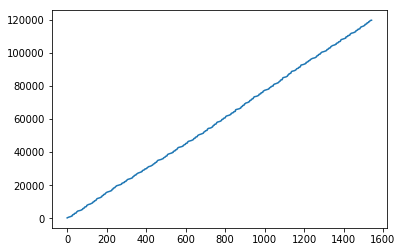

In [29]:
pks1 = PanTompkinsPeaks2(data, fs=2000)
plt.plot(pks1)

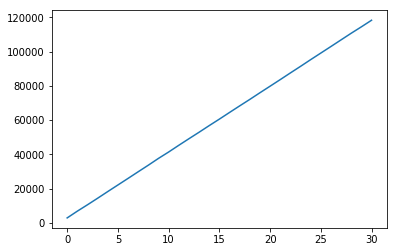

In [23]:
plt.plot(figsize =(12,8))
pks = sp.signal.find_peaks((MovingSum(np.square(np.diff(BandpassFilter(data))))), height = 4000, distance = 3000)[0]
TWaveDiscrimination(data, pks, fs=2000, twave_pd_ms=360, slope_window_ms=60)
plt.plot(TWaveDiscrimination(data, pks, fs=2000, twave_pd_ms=3600, slope_window_ms=600))
#plt.plot(pks, (MovingSum(np.square(np.diff(BandpassFilter(data)))))[pks], 'r.', ms = 10)

In [19]:
def Plot(x, fs, xlim=None, title=''):
    plt.figure(figsize=(12, 8))
    ts = np.arange(len(x)) / fs
    plt.plot(ts, x)
    pks = PanTompkinsPeaks2(x, fs)
    plt.plot(ts[pks], x[pks], 'r.', ms=10)
    plt.xlabel('Time (sec)')
    plt.title(title)
    if xlim is not None:
        plt.xlim((ts[xlim[0]], ts[xlim[1]]))

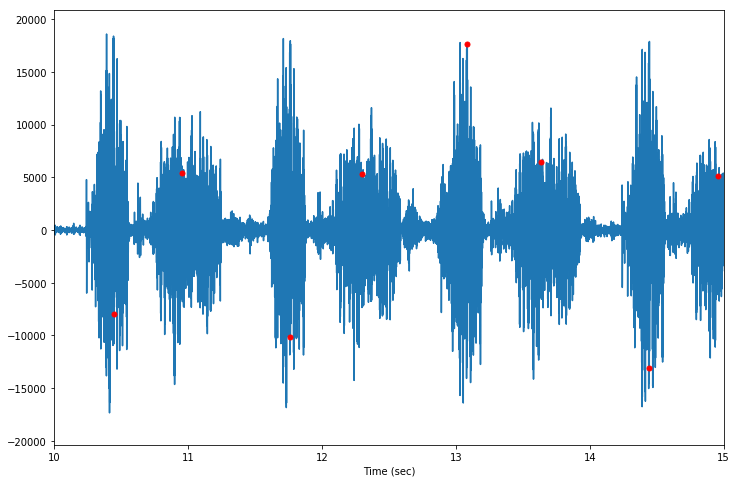

In [33]:
Plot(data, 2000, (20000, 30000) )